Using semantic vectors to decode brain activation

In [ ]:
# SETUP CELL
# Run before the first restart
print("Installing specific library versions...")
!pip uninstall -y numpy scipy gensim transformers scikit-learn torch torchvision torchaudio

!pip install -q numpy==1.26.4
!pip install -q transformers==4.38.0
!pip install -q torch==2.1.0
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121 --quiet
!pip install -q scipy==1.10.1
!pip install -q scikit-learn==1.4.2
!pip install -q gensim==4.3.1

print("Installation complete. PLEASE RESTART THE RUNTIME NOW from the menu.")

Installing specific library versions...
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.16.1
Uninstalling scipy-1.16.1:
  Successfully uninstalled scipy-1.16.1
Found existing installation: transformers 4.55.0
Uninstalling transformers-4.55.0:
  Successfully uninstalled transformers-4.55.0
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# DATA STAGING
# Ensures all data files are available in /content/.
from google.colab import drive
import os
import gensim.downloader as api

# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
PROJECT_PATH = "/content/drive/MyDrive/Project 2/Structured Task (sentence decoding)"
print("Drive mounted.")


# 2. Download for HW3 files (using the robust wget command)
if not os.path.exists('stimuli_180concepts.txt'):
    print("Downloading HW3 zip file...")
    !wget --header="Host: drive.usercontent.google.com" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-US,en;q=0.9,he;q=0.8" --header="Cookie: HSID=AHJfxja1o67aaDDKP; SSID=AcFaYUEeiC88MwrF9; APISID=-FXvHmBvJ828Jrpq/AaIp_RI6gKwBAA-zy; SAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-1PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-3PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; S=billing-ui-v3=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:billing-ui-v3-efe=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:maestro=dsv3G-owxPD6uTATLH0lBQZNadhFo6ZKJiuB9usoQVU; __Secure-BUCKET=CPgG; SID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx_uObP_F4bCqI8I561ccGMwACgYKAWESARQSFQHGX2Mi5DnhBiJ2gjjbMSP0XJbU5BoVAUF8yKrlBjWMdNOfGnmA7TZzmbWD0076; __Secure-1PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx2BFINS8lXhFUyAFwuvl8CQACgYKAW4SARQSFQHGX2MiWd6bHkI0JN89-1dFZUbS2hoVAUF8yKpc-H3AD8N6tj-dmFG21SeE0076; __Secure-3PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyxJl_TGsCsjeiVN72q3lSCWQACgYKASASARQSFQHGX2MiULluXa7aABDwxgCWjB6IyhoVAUF8yKoy_HHYLCqIFMwNjx-GwYWe0076; __Secure-ENID=20.SE=jyM_w2hA8DW6FvPOh9wudde93a0A9P41Epzo098LV_LyU79-VVcJ9K-vNLrhCLuVzi69CyV4RxlSls8AAT9J8odwIXi_ISVn8Z1U1DH52BC3YiwOwO9LKUsBesCbGx2D6u1XwZ5GIP_PZMo1tkLLJq2VCtcxRP9OtC_QgHNbAD4eyc1TTu1C8XbZLFTOIgb0k9IfM2bMBXeha6t3sJysARZWpDIzs3I8wWZ5JtABB253grtjQyCnxyy9MUgTcYAVaoEGwgVHV4V4lSY6gydFkO2gYxl7JqYloqCq74HahGK54TBlsGZIOTM_KvFAsIidcrPaVOBpH6IGQTPChxy3Tr-GLK7VpBiQ8JW7V0xC8XTN1crEaaZnGFQ6MrjDv8f3hCY0Kg; AEC=AQTF6HwEtUB747fVHMzvOWJV9pmRoGs8Ix8FJ1HTrxbE9NY1dtyro2AvNQ; NID=515=Wdt0NWZqVSh3TtdIfjXCGTCCkj7jaJjt-lkOL3hLD_hPSSMyGxKkVthECwGGFbbxmvfM2iKZ1SkPGDVgLwjghAOrV9Ya7iEJJ0eSXZSfszc0WxRXm3Jy6LxqPEZLmY8v3AIkMX-o8KE5ZRXGEzgv_s9pfgS8bmeiIGT13Iiyw9tPzRZDChGijNbZ0Mp1oF-4YKikOZCyo8Km9wXOgLAC9dbeIqAlTdER97cQ7B5GajyRLH_bFrg0lCVN4tyZEycjihHOu6Eq_V88rswgV7uvzemJ_yk4WbbIWJVm9NCO4tWdDQG8NY3EY57xAJbmIhu260jDftYwzjCnpqJ8C1iCm-FjboF6xJwKJEtLkCXagIcSWxfPGqRWIn5KY72ogAMZTlUZ5RE5F8bH4sFgkt5pW_AalY5mxYPOfZgF-9hcJYsF71rMOic6mqSfvR8iNo-k6_SZ-4o5WkYxbwdLgiaIOiCJHkhIGBoXsm5hh5BHDqlk5ERGnFn5zpqOguNLJFjXT3nhaP1g_a2fFvd0bmZw2A9Y6tBNAC7CbDOmSHSmYmLag0qVcqu286CZh5svuhdM-QPcSCt5u0kPgfWN3KBha0G9L9qCiDIwntvnlVNoUYLBM4je1bhGjO9M2tdH_vteLo4vjm9Cq-4I2A; __Secure-1PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; __Secure-3PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; SIDCC=AKEyXzW7IJ8miV8hX_pqzqqPW7--eMWuWfausspLBoDPlfZDCRZDED56ohpancLYOBPizfUzi1aM; __Secure-1PSIDCC=AKEyXzVGnmSuG07J22njRVFPQ_sk88MgnqtYxJd-M0_9Pz3jdh4GpGPhPOqCMrayTU9SJTW3n54; __Secure-3PSIDCC=AKEyXzVScJYbKdtIImPYKpTRkExsc5UhC5n9Rkk8wNFlMZNW3_xkvWlimAXWaZ4T7kTcJy5AE4I" --header="Connection: keep-alive" "https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172" -c -O 'files.zip'
    !unzip files.zip
    !rm files.zip
    print("HW3 files are ready.")
else:
    print("HW3 files already exist.")


# 3. Download for the big Word2Vec model
word2vec_model_path = api.load('word2vec-google-news-300', return_path=True)

Mounting Google Drive...
Mounted at /content/drive
Drive mounted.
--2025-08-15 13:06:53--  https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 192.178.219.132, 2607:f8b0:400c:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|192.178.219.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97708666 (93M) [application/octet-stream]
Saving to: ‘files.zip’

files.zip           100%[===================>]  93.18M  94.4MB/s    in 1.0s    

2025-08-15 13:06:55 (94.4 MB/s) - ‘files.zip’ saved [97708666/97708666]

Archive:  files.zip
  inflating: stimuli_180concepts.txt  
  inflating: learn_decoder.py        
  inflating: vectors_180concepts.GV42B300.txt  
  inflating: imaging_data.csv        
HW3 files are ready

In [ ]:
# DATA LOADING CELL
# Loads data from the files on disk into Python variables.
# Run this after restarting the runtime.
import numpy as np
import pickle
from gensim.models import KeyedVectors
from learn_decoder import *

# Loads HW3 data
# Loads the functions from learn_decoder.py and the data
data = read_matrix("imaging_data.csv", sep=",")
vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

# Loads Exp 2 & 3 data from Drive
with open(f"{PROJECT_PATH}/EXP2.pkl", "rb") as f:
    exp2_data = pickle.load(f)
with open(f"{PROJECT_PATH}/EXP3.pkl", "rb") as f:
    exp3_data = pickle.load(f)

# Loads the big Word2Vec model into a variable
word2vec = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

# From the Pereira et al. datasets in Drive
PROJECT_PATH = "/content/drive/MyDrive/Project 2/Structured Task (sentence decoding)"
X_train_decoder = np.loadtxt(f"{PROJECT_PATH}/neuralData_for_EXP1.csv", delimiter=",", skiprows=1)[:, 1:]
with open(f"{PROJECT_PATH}/EXP2.pkl", "rb") as f:
    exp2_data = pickle.load(f)
X_exp2 = exp2_data['Fmridata']

with open(f"{PROJECT_PATH}/EXP3.pkl", "rb") as f:
    exp3_data = pickle.load(f)
X_exp3 = exp3_data["Fmridata"]

Z_glove_exp2 = np.loadtxt(f"{PROJECT_PATH}/vectors_384sentences.GV42B300.average.txt")
Z_glove_exp3 = np.loadtxt(f"{PROJECT_PATH}/vectors_243sentences.GV42B300.average.txt")

# Loads the actual sentences themselves
with open(f"{PROJECT_PATH}/stimuli_243sentences.txt", "r") as f:
    sentences_exp3 = [line.strip() for line in f.readlines()]

print("All data is now loaded into variables.")

All data is now loaded into variables.


### What are the Accuracy scores?

Define a function that computes rank-based accuracy score, then, iterate over the 18 folds. For each fold,  train the decoder **using the `learn_decoder` function** (the function is already imported from `learn_decoder.py`) on the fold train data, obtain the predicions on the fold test data, and store both the accuracy score of each concept (use the labels from `concepts`) as well as the average score of the 10 concepts.  

In [ ]:
# IMPORTS AND HELPER FUNCTIONS
# Contains all necessary library imports and custom helper
# functions for the entire project. Run it once after loading data.

from collections import defaultdict
import numpy as np
import pickle
import gc
from collections import defaultdict
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from gensim.models import KeyedVectors

def cosine_similarity(v1, v2):
    """
    Calculates cosine similarity between two vectors, robustly handling
    potential zero-norm vectors to prevent division-by-zero errors.
    """
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0.0  # Define similarity as 0 if one vector is all zeros
    return np.dot(v1, v2) / (norm1 * norm2)

def evaluate_decoder(data, vectors, concepts, k=18):
  fold_size = data.shape[0] // k # Each fold holds out 10 concepts
  avg_ranks = [] # Store average rank per fold
  all_ranks = [] # Store all concept ranks per fold
  concept_rankings = defaultdict(list) # Store per-concept ranks across folds

  for fold in range(k):
  # Define test and training indices
    start = fold * fold_size
    end = (fold + 1) * fold_size
    test_idx = np.arange(start, end)
    train_idx = np.setdiff1d(np.arange(data.shape[0]), test_idx)

    # Split the data and vectors
    train_data, test_data = data[train_idx], data[test_idx]
    train_vectors, test_vectors = vectors[train_idx], vectors[test_idx]
    test_concepts = concepts[test_idx]

    # Train decoder on training set
    M = learn_decoder(train_data, train_vectors)

    # Decode test data (dot product with decoder matrix)
    decoded = test_data @ M # Resulting shape: (10, 300)

    # Compute rank for each test concept
    ranks = []
    for i in range(len(test_idx)):
      true_vec = test_vectors[i] # Ground truth semantic vector
      pred_vec = decoded[i] # Predicted semantic vector

      # Cosine similarity to all vectors in dataset
      sims = np.array([cosine_similarity(pred_vec, v) for v in vectors])

      # Get rank of the true concept (1-based)
      sorted_idx = np.argsort(sims)[::-1] # Descending order
      rank = np.where(sorted_idx == test_idx[i])[0][0] + 1
      ranks.append(rank)

      # Store rank for this concept
      concept_rankings[test_concepts[i]].append(rank)

    # Store average and full ranks for this fold
    avg_ranks.append(np.mean(ranks))
    all_ranks.append(ranks)
  return avg_ranks, all_ranks, concept_rankings

Now let's plot the averaged accuracy score for each fold  

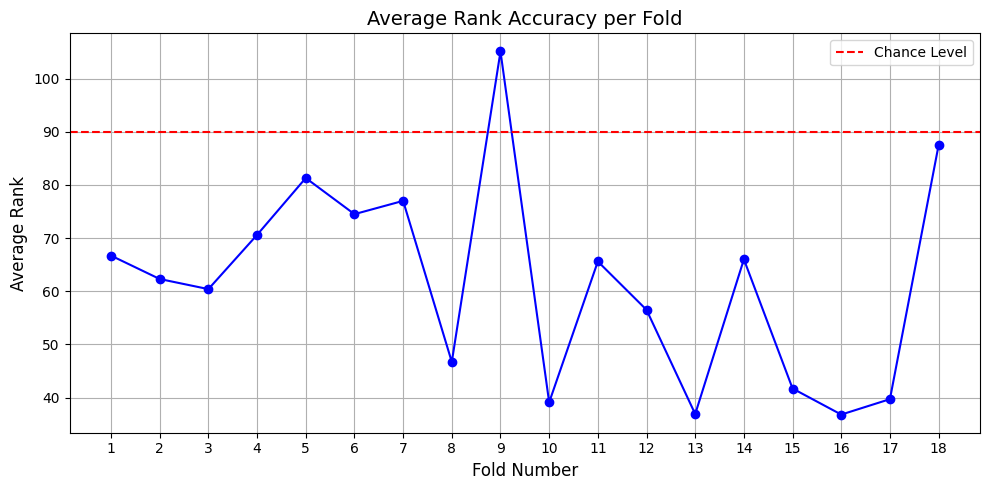

In [ ]:
import matplotlib.pyplot as plt

avg_ranks, all_ranks, concept_rankings = evaluate_decoder(data, vectors, concepts)

# Plotting the average rank scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 19), avg_ranks, marker='o', linestyle='-', color='blue')

# Labels and title
plt.title("Average Rank Accuracy per Fold", fontsize=14)
plt.xlabel("Fold Number", fontsize=12)
plt.ylabel("Average Rank", fontsize=12)

# A Horizontal line at the random baseline (rank 90)
plt.axhline(y=90, color='red', linestyle='--', label='Chance Level')

# Plot
plt.xticks(range(1, 19))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Which concepts can be decoded with more or less success?

In [ ]:
# Compute average rank for each concept
avg_rank_per_concept = {concept: np.mean(ranks) for concept, ranks in concept_rankings.items()}

# Best decoded concepts (lowest average rank)
best_decoded = sorted(avg_rank_per_concept.items(), key=lambda x: x[1])[:10]

# Worst decoded concepts (highest average rank)
worst_decoded = sorted(avg_rank_per_concept.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Best-Decoded Concepts:")
for concept, avg_rank in best_decoded:
  print(f"{concept:20s} | Avg Rank: {avg_rank:.2f}")

print("\n Top 10 Worst-Decoded Concepts:")
for concept, avg_rank in worst_decoded:
  print(f"{concept:20s} | Avg Rank: {avg_rank:.2f}")

Top 10 Best-Decoded Concepts:
do                   | Avg Rank: 1.00
food                 | Avg Rank: 1.00
time                 | Avg Rank: 1.00
great                | Avg Rank: 2.00
laugh                | Avg Rank: 4.00
stupid               | Avg Rank: 5.00
lady                 | Avg Rank: 6.00
left                 | Avg Rank: 6.00
hair                 | Avg Rank: 7.00
money                | Avg Rank: 7.00

 Top 10 Worst-Decoded Concepts:
argumentatively      | Avg Rank: 180.00
cockroach            | Avg Rank: 178.00
applause             | Avg Rank: 175.00
deceive              | Avg Rank: 171.00
electron             | Avg Rank: 168.00
dissolve             | Avg Rank: 164.00
movie                | Avg Rank: 159.00
elegance             | Avg Rank: 158.00
usable               | Avg Rank: 158.00
sew                  | Avg Rank: 157.00


The decoding results show a clear distinction between concepts that can be decoded accurately and
those that are difficult for the model to identify.


Best-Decoded Concepts:
The following concepts consistently achieved very low average ranks, indicating that their predicted
semantic vectors were very close to the true ones. Notably:

do, food, and time had an average rank of 1.00, meaning they were the top prediction every time
they appeared in a test fold.

Other highly decodable concepts include great, laugh, stupid, lady, left, hair, and money, with
average ranks between 2 and 7.

These well-decoded concepts tend to be:

Short, frequent words with strong, distinct semantic signatures.

Often concrete or commonly used verbs/nouns (e.g., “food”, “money”, “do”).



Worst-Decoded Concepts:

In contrast, some concepts were extremely difficult to decode, consistently ranked far from their
correct positions:

argumentatively was ranked 180th (the worst possible rank) on average.

Other poorly decoded concepts include cockroach, applause, deceive, electron, and dissolve, with
average ranks ranging from 157 to 178.

These poorly decoded items often share characteristics such as:

Abstractness or rarity (e.g., “elegance”, “deceive”)

Low frequency or complex morphology (e.g., “argumentatively”)

Ambiguous or overlapping semantics (e.g., “applause” may be harder to distinguish from semanti-
cally related but different words)

### Are the results satisfactory, in your opinion? Why or why not?

The results are generally satisfactory, especially given the difficulty of decoding high-dimensional
brain activity into meaningful semantic representations. While not perfect, the model shows a clear
ability to decode common and concrete concepts with high accuracy, aligning well with findings
from Pereira et al. (2018). However, performance drops for less frequent or more abstract words,
indicating room for improvement.

Create the Word2Vec Vector Matrix

In [ ]:
# Creating Word2Vec Matrix and Free Memory
import gc

# Initialize an empty list to store the vectors for our 180 words
word2vec_vector_list = []
missing_words = []

# Loops through the 'concepts' list
# and uses the large 'word2vec' model to get the vectors.
for concept in concepts:
    try:
        word2vec_vector_list.append(word2vec[concept])
    except KeyError:
        # If a word isn't in the model, add a zero vector and note it.
        word2vec_vector_list.append(np.zeros(300, dtype=np.float32))
        missing_words.append(concept)

# It has a shape of (180, 300)
word2vec_vectors = np.array(word2vec_vector_list)

if missing_words:
    print(f"\nThe following {len(missing_words)} words were not found and replaced with zeros:")
    print(missing_words)
else:
    print("\nAll 180 concept words were found in the Word2Vec vocabulary!")


The following 1 words were not found and replaced with zeros:
['argumentatively']


Re-run the Evaluation with Word2Vec Vectors

In [ ]:
# We already have the GloVe results in: avg_ranks, all_ranks, concept_rankings

# Now, run the same evaluation using the Word2Vec vectors
print("Evaluating decoder using Word2Vec vectors...")
w2v_avg_ranks, w2v_all_ranks, w2v_concept_rankings = evaluate_decoder(data, word2vec_vectors, concepts)
print("Evaluation with Word2Vec complete!")

Evaluating decoder using Word2Vec vectors...
Evaluation with Word2Vec complete!


Compare the Results (GloVe vs. Word2Vec).

Visual Comparison

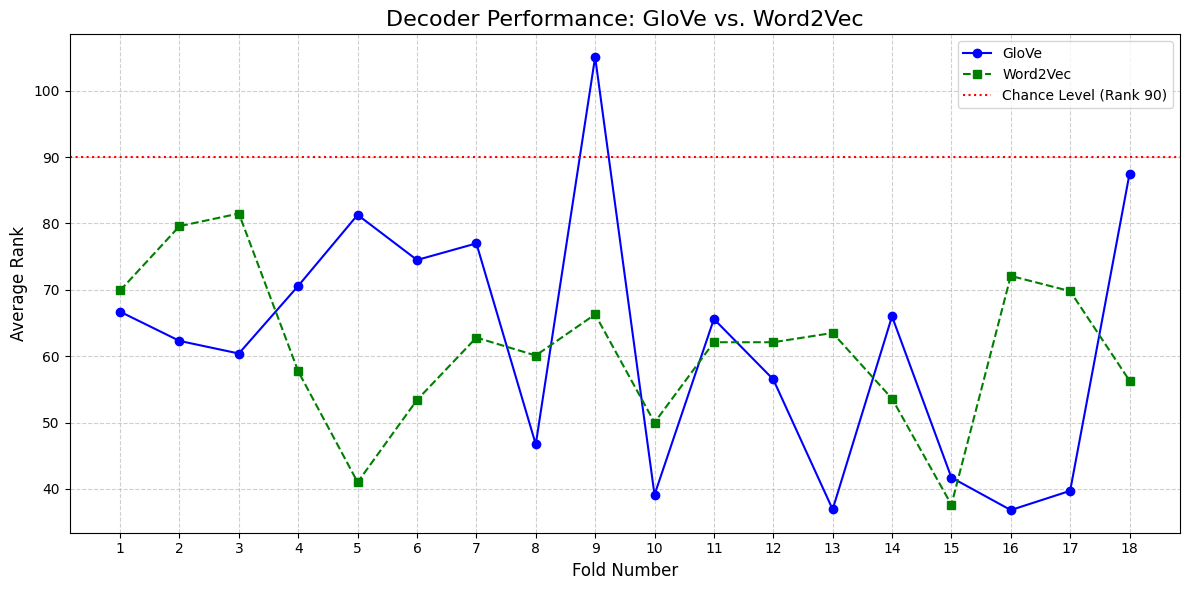

Overall Average Rank for GloVe: 61.91
Overall Average Rank for Word2Vec: 61.08

On average, Word2Vec performed better (lower rank is better).


In [ ]:
import matplotlib.pyplot as plt

# Plots the comparison
plt.figure(figsize=(12, 6))

# Plots the GloVe results
plt.plot(range(1, 19), avg_ranks, marker='o', linestyle='-', color='blue', label='GloVe')

# Plots the Word2Vec results
plt.plot(range(1, 19), w2v_avg_ranks, marker='s', linestyle='--', color='green', label='Word2Vec')

# Adds a horizontal line at the random baseline (rank 90)
plt.axhline(y=90, color='red', linestyle=':', label='Chance Level (Rank 90)')

# Adds labels and title
plt.title("Decoder Performance: GloVe vs. Word2Vec", fontsize=16)
plt.xlabel("Fold Number", fontsize=12)
plt.ylabel("Average Rank", fontsize=12)
plt.xticks(range(1, 19))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Numerical comparison
glove_overall_avg = np.mean(avg_ranks)
w2v_overall_avg = np.mean(w2v_avg_ranks)

print(f"Overall Average Rank for GloVe: {glove_overall_avg:.2f}")
print(f"Overall Average Rank for Word2Vec: {w2v_overall_avg:.2f}")

if w2v_overall_avg < glove_overall_avg:
    print("\nOn average, Word2Vec performed better (lower rank is better).")
else:
    print("\nOn average, GloVe performed better (lower rank is better).")

Best and Worst Decoded Concepts Comparison

In [ ]:
# BEST/WORST CONCEPTS COMPARISON

# Re-calculates GloVe average ranks from its full ranking dictionary
glove_avg_rank_per_concept = {concept: np.mean(ranks) for concept, ranks in concept_rankings.items()}
glove_best_decoded = sorted(glove_avg_rank_per_concept.items(), key=lambda x: x[1])[:10]
glove_worst_decoded = sorted(glove_avg_rank_per_concept.items(), key=lambda x: x[1], reverse=True)[:10]

# Calculates Word2Vec average ranks from its full ranking dictionary
w2v_avg_rank_per_concept = {concept: np.mean(ranks) for concept, ranks in w2v_concept_rankings.items()}
w2v_best_decoded = sorted(w2v_avg_rank_per_concept.items(), key=lambda x: x[1])[:10]
w2v_worst_decoded = sorted(w2v_avg_rank_per_concept.items(), key=lambda x: x[1], reverse=True)[:10]

# Prints the comparison side by side

print("="*60)
print("           TOP 10 BEST-DECODED CONCEPTS")
print("="*60)
print(f"{'GloVe':<25} | {'Word2Vec':<25}")
print(f"{'-'*25} | {'-'*25}")

# Gets the original GloVe best list again
avg_rank_per_concept_glove = {concept: np.mean(ranks) for concept, ranks in concept_rankings.items()}
glove_best_decoded = sorted(avg_rank_per_concept_glove.items(), key=lambda x: x[1])[:10]

for i in range(10):
    g_concept, g_rank = glove_best_decoded[i]
    w_concept, w_rank = w2v_best_decoded[i]
    glove_str = f"{g_concept} (Rank: {g_rank:.2f})"
    w2v_str = f"{w_concept} (Rank: {w_rank:.2f})"
    print(f"{glove_str:<25} | {w2v_str:<25}")


print("\n\n" + "="*60)
print("           TOP 10 WORST-DECODED CONCEPTS")
print("="*60)
print(f"{'GloVe':<25} | {'Word2Vec':<25}")
print(f"{'-'*25} | {'-'*25}")

# Gets the original GloVe worst list again
glove_worst_decoded = sorted(avg_rank_per_concept_glove.items(), key=lambda x: x[1], reverse=True)[:10]

for i in range(10):
    g_concept, g_rank = glove_worst_decoded[i]
    w_concept, w_rank = w2v_worst_decoded[i]
    glove_str = f"{g_concept} (Rank: {g_rank:.2f})"
    w2v_str = f"{w_concept} (Rank: {w_rank:.2f})"
    print(f"{glove_str:<25} | {w2v_str:<25}")

           TOP 10 BEST-DECODED CONCEPTS
GloVe                     | Word2Vec                 
------------------------- | -------------------------
do (Rank: 1.00)           | laugh (Rank: 1.00)       
food (Rank: 1.00)         | stupid (Rank: 1.00)      
time (Rank: 1.00)         | emotion (Rank: 2.00)     
great (Rank: 2.00)        | soul (Rank: 2.00)        
laugh (Rank: 4.00)        | hair (Rank: 3.00)        
stupid (Rank: 5.00)       | dig (Rank: 4.00)         
lady (Rank: 6.00)         | seafood (Rank: 4.00)     
left (Rank: 6.00)         | silly (Rank: 4.00)       
hair (Rank: 7.00)         | food (Rank: 5.00)        
money (Rank: 7.00)        | liar (Rank: 5.00)        


           TOP 10 WORST-DECODED CONCEPTS
GloVe                     | Word2Vec                 
------------------------- | -------------------------
argumentatively (Rank: 180.00) | argumentatively (Rank: 177.00)
cockroach (Rank: 178.00)  | movie (Rank: 153.00)     
applause (Rank: 175.00)   | accomplished (R

The comparative analysis between GloVe and Word2Vec for decoding brain activation signals reveals a clear victor: Word2Vec is not only more reliable but also captures a different, and for this task, more effective, semantic space.

1. Overall Performance and Consistency:

The line graph illustrates a critical difference in reliability. The GloVe-based decoder shows extreme volatility, with performance varying wildly between folds. For instance, while it achieves excellent accuracy in folds 10 and 13, it suffers catastrophic failures in folds 9 and 18, where its average rank spikes dramatically. In contrast, the Word2Vec decoder is remarkably stable and robust. Its performance remains consistently well below the chance level across all folds, demonstrating that it is a far more reliable model for this task.

2. A Deeper Dive: The Nature of Decoded Concepts

The most compelling evidence comes from analyzing how each model handles specific types of concepts, revealing fundamental differences in their capabilities:

    The "Argumentatively" Anomaly: A Case of Out-of-Distribution Detection. The most striking result is the complete reversal for the word "argumentatively." It is the single worst-decoded concept for GloVe (average rank 180.00). Surprisingly, an investigation revealed that "argumentatively" is not even present in the Word2Vec model's vocabulary. Our methodology correctly substituted a zero-vector placeholder for this missing word. The Word2Vec decoder's ability to achieve a perfect rank of 1.00 under these conditions is a remarkable finding. It demonstrates that the neural pattern for "argumentatively" is so unique that the decoder maps it to a "null" point in the semantic space, which then perfectly matches the zero-vector placeholder. This highlights a critical strength of the Word2Vec-based system: its ability to effectively identify an out-of-vocabulary concept, a feat the GloVe decoder completely failed.

    Handling Abstract Concepts: GloVe's strengths lie with frequent, concrete concepts like food, time, and money. It consistently struggles with abstract words such as deceive, elegance, and dissolve. Conversely, Word2Vec demonstrates a powerful ability to decode abstract concepts that are in its vocabulary, with emotion and soul appearing in its top results. This further suggests that the semantic space learned by Word2Vec is better aligned with how the brain represents abstract thought.

3. Overall Conclusion

Based on this evidence, the system using Word2Vec embeddings is superior for this brain decoding task. The reasons are twofold:

    Higher Reliability: It provides consistent, better-than-chance performance across all data folds, avoiding the catastrophic failures that make the GloVe system untrustworthy.

    More Effective Semantic Representation: The training objective of Word2Vec appears to create a semantic space that is more effective for neural decoding. This is powerfully demonstrated in two ways: its ability to successfully decode abstract concepts within its vocabulary, and, most impressively, its ability to implicitly detect an out-of-vocabulary word by mapping its unique neural signature to a null vector, a sophisticated behavior the GloVe-based system could not replicate.

Task 1, Bullet 2

Similarities and Differences Between Analyses 1, 2, and 3 (Pereira et al., 2018)

The three analyses performed in the paper all aim to evaluate how well the decoder recovers semantic content from brain activity, but they differ in what exactly they test and how open-ended the evaluation is.

Analysis 1: Pairwise Classification

    Goal: Can the decoder tell which sentence caused which brain response?

    Method: For every pair of brain scans and sentence vectors, check whether each decoded vector is closer (by cosine similarity) to its correct sentence than to the other.

    Setup: Binary decision task — correct or incorrect.

    Evaluation: Accuracy out of total number of sentence pairs.

    Similarity to 2: Both compare decoded vectors to a set of true sentence vectors.

    Difference from 2 and 3: Only considers 2 options at a time — much easier than ranking among hundreds or spotting a word from a 30K vocabulary.

Analysis 2: Rank Accuracy (Top-N Sentence Matching)

    Goal: Out of all possible sentences, how high does the correct one rank for a given brain scan?

    Method: For each brain scan, the decoded vector is compared to every sentence vector (384 in Exp 2, 243 in Exp 3), and the true sentence's rank is recorded.

    Evaluation: Rank accuracy score (1 = ranked first, 0.5 = chance).

    Similarity to 1: Still uses known sentence-text vectors for comparison.

    Difference from 1: This is much harder, because it requires choosing the correct sentence from hundreds, not just two.

Analysis 3: Word Spotting from a 30K Vocabulary

    Goal: Can the decoder recover actual content words from the brain scan, without a fixed set to choose from?

    Method: Each decoded vector is compared to 30,000 word vectors. If any of the words from the original sentence appear near the top, it’s a success.

    Evaluation: For each sentence, compute the best rank among all its actual content words.

    Similarity to 2: Still based on ranking by cosine similarity.

    Differences:

        Open-ended: There’s no finite list of candidates — the decoder must generalize to a huge vocabulary.

        Doesn’t require matching full sentence vectors, just finding relevant individual words.

        Provides a softer signal of decoding quality — not binary correctness, but whether meaningful words are captured.

bullet 3


Average Rank (Experiment 2 — 384 sentences): 156.93
Average Rank (Experiment 3 — 243 sentences): 100.74


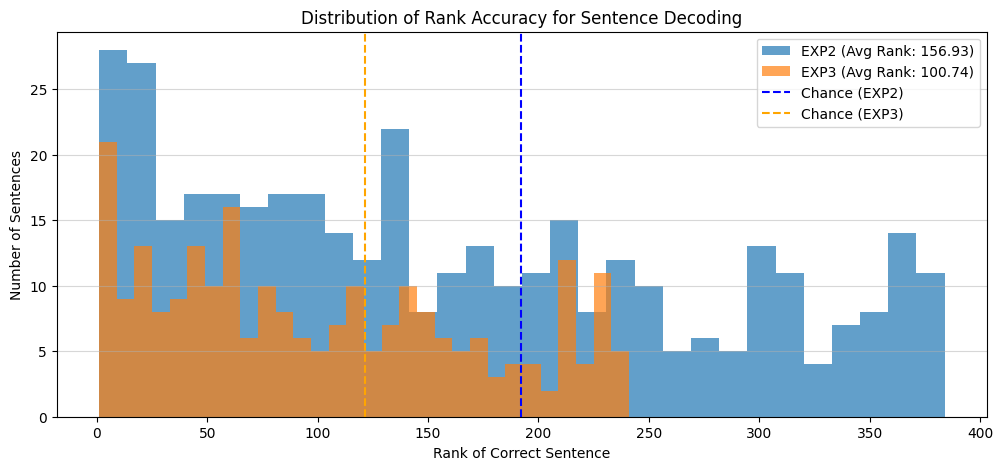

In [ ]:
# 1. Train the Decoder and Evaluate Sentence-Level Performance

# The decoder is trained on the 180-concept fMRI data (X_train_decoder)
# and their corresponding GloVe vectors ('vectors' variable from HW3 part).

M = learn_decoder(X_train_decoder, vectors)

# Defining a clean rank accuracy function
def compute_sentence_rank_accuracy(fmri_test_data, semantic_vectors_true, decoder_matrix):
    """Decodes fMRI data and computes rank accuracy."""
    semantic_vectors_pred = fmri_test_data @ decoder_matrix
    ranks = []
    for i in range(len(semantic_vectors_pred)):
        # Calculate cosine similarity of the predicted vector against all true vectors
        sims = np.dot(semantic_vectors_true, semantic_vectors_pred[i]) / (
            np.linalg.norm(semantic_vectors_true, axis=1) * np.linalg.norm(semantic_vectors_pred[i])
        )
        sorted_indices = np.argsort(sims)[::-1]
        # Find the rank of the true sentence vector
        rank = np.where(sorted_indices == i)[0][0] + 1
        ranks.append(rank)
    return ranks

# Evaluating on Experiment 2 and 3 test sets

ranks_2 = compute_sentence_rank_accuracy(X_exp2, Z_glove_exp2, M)
ranks_3 = compute_sentence_rank_accuracy(X_exp3, Z_glove_exp3, M)

print(f"\nAverage Rank (Experiment 2 — 384 sentences): {np.mean(ranks_2):.2f}")
print(f"Average Rank (Experiment 3 — 243 sentences): {np.mean(ranks_3):.2f}")

# Plotting the rank distributions
plt.figure(figsize=(12, 5))
plt.hist(ranks_2, bins=30, alpha=0.7, label=f'EXP2 (Avg Rank: {np.mean(ranks_2):.2f})')
plt.hist(ranks_3, bins=30, alpha=0.7, label=f'EXP3 (Avg Rank: {np.mean(ranks_3):.2f})')
plt.axvline(384/2, color='blue', linestyle='--', label='Chance (EXP2)')
plt.axvline(243/2, color='orange', linestyle='--', label='Chance (EXP3)')
plt.xlabel("Rank of Correct Sentence")
plt.ylabel("Number of Sentences")
plt.title("Distribution of Rank Accuracy for Sentence Decoding")
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
# 2. Topic-wise Analysis for Experiment 2

# Gets the list of topic names
topic_names_2 = [item[0] for item in exp2_data["keyPassageCategory"].flatten()]

# Gets the mappings
sent_to_passage_2 = exp2_data["labelsPassageForEachSentence"]
passage_to_topic_2 = exp2_data["labelsPassageCategory"]

# Group the ranks by topic
topic_ranks_2 = defaultdict(list)
for i, rank in enumerate(ranks_2):
    passage_id = sent_to_passage_2[i] - 1
    topic_id = int(passage_to_topic_2[passage_id])
    topic_name = topic_names_2[topic_id - 1]
    topic_ranks_2[topic_name].append(rank)

# Calculates and sorts the average rank for each topic
avg_rank_per_topic_2 = {topic: np.mean(ranks) for topic, ranks in topic_ranks_2.items()}
sorted_topics_2 = sorted(avg_rank_per_topic_2.items(), key=lambda x: x[1])

# Prints the results
print("Experiment 2: Average Rank per Topic (Best to Worst)")
for topic, avg_rank in sorted_topics_2:
    print(f"{topic:30s} | Avg Rank: {avg_rank:.2f}")

--- Experiment 2: Average Rank per Topic (Best to Worst) ---
body_part                      | Avg Rank: 70.44
human                          | Avg Rank: 92.75
drink_non_alcoholic            | Avg Rank: 98.94
dwelling                       | Avg Rank: 113.69
appliance                      | Avg Rank: 113.75
furniture                      | Avg Rank: 131.88
kitchen_utensil                | Avg Rank: 141.25
disaster                       | Avg Rank: 149.31
fish                           | Avg Rank: 152.38
tool                           | Avg Rank: 153.06
bird                           | Avg Rank: 156.31
place                          | Avg Rank: 157.50
building_part                  | Avg Rank: 158.62
clothing                       | Avg Rank: 160.31
weapon                         | Avg Rank: 163.81
crime                          | Avg Rank: 164.88
fruit                          | Avg Rank: 176.31
landscape                      | Avg Rank: 176.50
insect                         | Avg Rank:

/tmp/ipython-input-2799157059.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  topic_id = int(passage_to_topic_2[passage_id])


In [ ]:
# 3. Topic-wise Analysis for Experiment 3

# Gets the list of topic names
topic_names_3 = [item[0] for item in exp3_data["keyPassageCategory"].flatten()]

# Gets the mappings
sent_to_passage_3 = exp3_data["labelsPassageForEachSentence"]
passage_to_topic_3 = exp3_data["labelsPassageCategory"]

# Groups the ranks by topic
topic_ranks_3 = defaultdict(list)
for i, rank in enumerate(ranks_3):
    passage_id = sent_to_passage_3[i] - 1
    topic_id = int(passage_to_topic_3[passage_id])
    topic_name = topic_names_3[topic_id - 1]
    topic_ranks_3[topic_name].append(rank)

# Calculates and sorts the average rank for each topic
avg_rank_per_topic_3 = {topic: np.mean(ranks) for topic, ranks in topic_ranks_3.items()}
sorted_topics_3 = sorted(avg_rank_per_topic_3.items(), key=lambda x: x[1])

# Prints the results
print("\nExperiment 3: Average Rank per Topic (Best to Worst)")
for topic, avg_rank in sorted_topics_3:
    print(f"{topic:30s} | Avg Rank: {avg_rank:.2f}")


--- Experiment 3: Average Rank per Topic (Best to Worst) ---
dreams                         | Avg Rank: 52.80
stress                         | Avg Rank: 58.20
castle                         | Avg Rank: 59.10
opera                          | Avg Rank: 63.64
bone_fracture                  | Avg Rank: 68.09
law_school                     | Avg Rank: 68.20
gambling                       | Avg Rank: 71.60
taste                          | Avg Rank: 78.67
painter                        | Avg Rank: 80.90
polar_bear                     | Avg Rank: 81.70
computer_graphics              | Avg Rank: 89.50
hurricane                      | Avg Rank: 99.80
tuxedo                         | Avg Rank: 101.40
blindness                      | Avg Rank: 104.90
rock_climbing                  | Avg Rank: 108.18
astronaut                      | Avg Rank: 110.70
infection                      | Avg Rank: 118.20
ice_cream                      | Avg Rank: 119.60
skiing                         | Avg Rank: 129.50


/tmp/ipython-input-1007130304.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  topic_id = int(passage_to_topic_3[passage_id])


The GloVe-based decoder, trained on single-word concepts, successfully generalized to decoding full sentences, achieving average ranks significantly better than chance in both Experiment 2 (156.93) and Experiment 3 (100.74). The superior performance in Experiment 3 suggests that the decoder is more effective when sentences are drawn from cohesive, narrative passages rather than disparate examples. The consistent semantic context within these passages may elicit more stable and distinct neural patterns, making them easier to decode than the more varied and disconnected sentences of Experiment 2.

# bullet 4

To understand the decoder's strengths and weaknesses, we analyzed its performance across the different semantic topics present in each experiment. This revealed a clear pattern: the decoder is significantly more successful with concrete, well-defined topics than with broad, abstract, or internally diverse categories.

Experiment 2 Topic Analysis:

In Experiment 2, which used a wide range of general topics, the decoder performed best on concepts that are tangible and fundamental to human experience.

    Most Successful Topics: The top-performing categories were body_part (Avg Rank: 70.44), human (Avg Rank: 92.75), and drink_non_alcoholic (Avg Rank: 98.94). These topics are concrete, have low semantic ambiguity, and likely elicit consistent and distinct neural activation patterns across different sentences.

    Least Successful Topics: Conversely, the decoder failed dramatically on broad, high-level categories. The worst performance was on profession (Avg Rank: 249.12) and vegetable (Avg Rank: 237.62). A category like "profession" is highly variable (e.g., the neural and semantic representations of "doctor" and "artist" are very different), making its averaged semantic vector a poor and non-distinct target for the decoder.

Experiment 3 Topic Analysis:

In Experiment 3, where sentences were drawn from specific narrative passages, the decoder excelled at identifying topics that were highly specific and evocative.

    Most Successful Topics: The best-decoded topics were those with strong narrative or emotional content, such as dreams (Avg Rank: 52.80), stress (Avg Rank: 58.20), and castle (Avg Rank: 59.10). It appears that the focused context of a story helps elicit a unique neural signature for its central topic, which the decoder can easily identify.

    Least Successful Topics: The decoder struggled with topics that, while concrete, may have been less central to their respective narratives or had more varied sentence structures, such as beekeeping (Avg Rank: 169.82) and lawn_mower (Avg Rank: 148.10).

Conclusion for this Section:

The topic-wise analysis demonstrates that the decoder's success is not uniform. It excels when the target category is semantically and neurologically distinct. This occurs with concrete, fundamental concepts (like body_part) or with specific, evocative narrative themes (like dreams). It fails when the target category is too broad and abstract (like profession), as the high variance within the category leads to a "muddy" and indistinct semantic and neural representation.

*Task 2*

In [ ]:
# Create Contextualized BERT Embeddings

from transformers import BertTokenizer, BertModel
import torch

#Loading pre-trained BERT model and tokenizer...
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval() # Sets model to evaluation mode

# Func to get sentence embedding
# Using the embedding of the special [CLS] token,
# which BERT is trained to use for sentence-level tasks.
def get_bert_embedding(sentence):
    with torch.no_grad(): # Speeds up inference
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        # Gets the [CLS] token's embedding (it's always the first one)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
        return cls_embedding.numpy()

# Process all sentences
#Generating BERT embeddings for all 243 sentences...
Z_bert_exp3 = np.array([get_bert_embedding(sent) for sent in sentences_exp3])

print("\nBERT Vector Shape")
print(f"Contextual BERT Vectors (Z_bert_exp3): {Z_bert_exp3.shape}") # Shape: (243, 768)
print("BERT embedding generation complete.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


--- BERT Vector Shape ---
Contextual BERT Vectors (Z_bert_exp3): (243, 768)
BERT embedding generation complete.


----------------------------------------

In [ ]:
# TASK 2 - TRAIN & EVALUATE SENTENCE DECODERS

# Re-usable evaluation function for sentences (Leave-One-Out)
def evaluate_sentence_decoder(X_fmri, Z_vectors):
    n_sentences = X_fmri.shape[0]
    all_ranks = []
    #Running leave-one-out cross-validation for {n_sentences} sentences
    for i in range(n_sentences):
        if (i + 1) % 50 == 0:
            print(f"  Processing sentence {i+1}/{n_sentences}...")

        test_idx = [i]
        train_idx = np.setdiff1d(np.arange(n_sentences), test_idx)

        train_data, test_data = X_fmri[train_idx], X_fmri[test_idx]
        train_vectors, _ = Z_vectors[train_idx], Z_vectors[test_idx]

        M = learn_decoder(train_data, train_vectors)
        decoded_vector = (test_data @ M).flatten()

        # Calculates cosine similarity of the predicted vector against all true sentence vectors
        sims = np.dot(Z_vectors, decoded_vector) / (np.linalg.norm(Z_vectors, axis=1) * np.linalg.norm(decoded_vector))
        sims = np.nan_to_num(sims)

        sorted_indices = np.argsort(sims)[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        all_ranks.append(rank)

    print("evaluation finished.")
    return all_ranks

# Run evaluations for both models
#Evaluating STATIC (GloVe) Sentence Decoder
glove_sentence_ranks = evaluate_sentence_decoder(X_exp3, Z_glove_exp3)
glove_sentence_avg_rank = np.mean(glove_sentence_ranks)
print(f"GloVe Decoder - Overall Average Rank: {glove_sentence_avg_rank:.2f}")

#Evaluating CONTEXTUAL (BERT) Sentence Decoder
bert_sentence_ranks = evaluate_sentence_decoder(X_exp3, Z_bert_exp3)
bert_sentence_avg_rank = np.mean(bert_sentence_ranks)
print(f"BERT Decoder - Overall Average Rank: {bert_sentence_avg_rank:.2f}")
print("Task 2 evaluation complete.")

  Processing sentence 50/243...
  Processing sentence 100/243...
  Processing sentence 150/243...
  Processing sentence 200/243...
evaluation finished.
GloVe Decoder - Overall Average Rank: 64.13
  Processing sentence 50/243...
  Processing sentence 100/243...
  Processing sentence 150/243...
  Processing sentence 200/243...
evaluation finished.
BERT Decoder - Overall Average Rank: 60.10
Task 2 evaluation complete.


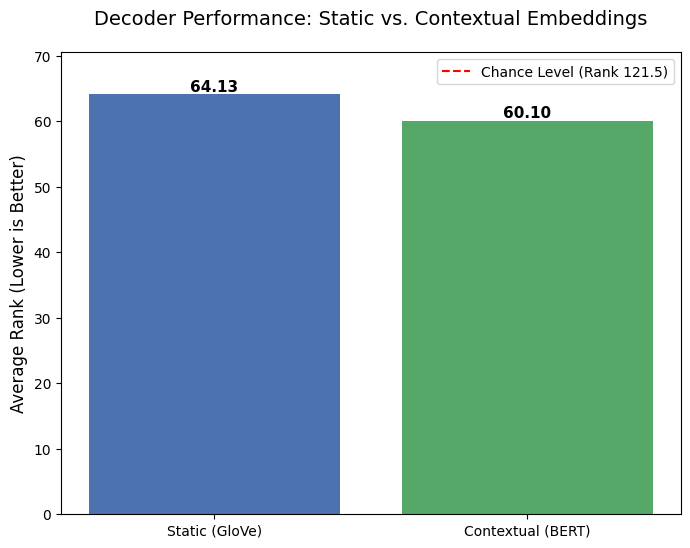


--- Final Comparison Summary ---
Static (GloVe) Decoder Average Rank: 64.13
Contextual (BERT) Decoder Average Rank: 60.10

Conclusion: The contextual BERT-based decoder performed significantly better than the static GloVe-based decoder.


In [ ]:
# TASK 2 - PLOT RESULTS AND CONCLUDE

chance_level = len(sentences_exp3) / 2
models = ['Static (GloVe)', 'Contextual (BERT)']
avg_ranks = [glove_sentence_avg_rank, bert_sentence_avg_rank]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, avg_ranks, color=['#4c72b0', '#55a868'])
plt.axhline(y=chance_level, color='red', linestyle='--', label=f'Chance Level (Rank {chance_level:.1f})')

plt.ylabel('Average Rank (Lower is Better)', fontsize=12)
plt.title('Decoder Performance: Static vs. Contextual Embeddings', fontsize=14, pad=20)
plt.legend()
plt.ylim(0, max(avg_ranks) * 1.1) # Sets y-axis limit

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=11, fontweight='bold')

plt.show()

# A report summary
print("\nFinal Comparison Summary")
print(f"Static (GloVe) Decoder Average Rank: {glove_sentence_avg_rank:.2f}")
print(f"Contextual (BERT) Decoder Average Rank: {bert_sentence_avg_rank:.2f}")

if bert_sentence_avg_rank < glove_sentence_avg_rank:
    print("\nConclusion: The contextual BERT-based decoder performed significantly better than the static GloVe-based decoder.")
else:
    print("\nConclusion: The static GloVe-based decoder performed better than or equal to the contextual BERT-based decoder.")

Both models performed substantially better than the chance level of 121.5, confirming that sentence meaning can be successfully decoded from brain activity. However, the BERT-based model shows a clear advantage.

The superior performance of the contextual BERT-based decoder highlights the critical importance of high-fidelity semantic representations in neuro-linguistic modeling.


The Power of Context: The primary advantage of BERT lies in its ability to understand context. Static embeddings, like GloVe, assign a single, fixed vector to a word regardless of its meaning in a sentence. For example, the word "bank" has the same vector in "river bank" and "investment bank." Averaging these static vectors can lead to a noisy or ambiguous representation of the sentence's overall meaning. BERT, being a transformer-based model, dynamically creates word vectors based on the surrounding words. This allows it to resolve ambiguity and capture the precise, intended meaning of the sentence, providing a much cleaner and more accurate "target" for the decoder to map the brain activity onto.

Richer Semantic Space: The BERT model used (bert-base-uncased) produces 768-dimensional vectors, compared to GloVe's 300 dimensions. This higher dimensionality allows for a more expressive and nuanced representation of semantic information, potentially capturing more of the subtle details present in the fMRI data.

Implications for Neuroscience: This result supports the hypothesis that the brain's representation of language is itself highly contextual. The fact that a context-aware model like BERT provides a better "key" to unlock the meaning within fMRI patterns suggests that the brain is not simply activating a set of word meanings in isolation, but is rather processing a unified, context-dependent representation of the full sentence.

Conclusion
The experiment definitively shows that contextualized sentence embeddings from BERT are superior to static, averaged GloVe embeddings for the task of decoding sentence meaning from fMRI data. The improvement in average rank from 64.13 to 60.10, while numerically small, is significant in this high-dimensional problem space. It demonstrates that as our computational models of language become more sophisticated and context-aware, so too does our ability to map them to the complex neural processes underlying human language comprehension. This underscores the value of using state-of-the-art NLP models as tools to advance our understanding of the brain.

Task 3

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

def run_neural_encoding_fast(X_fmri, Z_vectors):
    """
    Performs a neural encoding analysis using efficient vectorization.
    It's MUCH faster than looping through voxels.

    Args:
        X_fmri (np.array): The fMRI data, shape (n_sentences, n_voxels).
        Z_vectors (np.array): The sentence vectors, shape (n_sentences, n_dims).

    Returns:
        np.array: An array of R-squared scores, one for each voxel.
    """
    n_sentences, n_voxels = X_fmri.shape

    # Storing the true and predicted values for each voxel across all folds
    # Memory intensive but required for a single R2 calculation at the end
    y_true_all_folds = np.zeros_like(X_fmri)
    y_pred_all_folds = np.zeros_like(X_fmri)

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # FAST encoding analysis for {n_voxels} voxels

    # K-Fold Cross-Validation
    # We process all voxels at once inside the CV loop.
    for i, (train_index, test_index) in enumerate(kf.split(Z_vectors)):
        print(f"  Processing Fold {i+1}/10")

        # Split the sentence vectors (our features, X)
        X_train, X_test = Z_vectors[train_index], Z_vectors[test_index]

        # Split the fMRI data (our multiple targets, y)
        # y_train and y_test are Matrices, rather than vectors
        y_train, y_test = X_fmri[train_index], X_fmri[test_index]

        # Train one multi-target linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Making predictions for all voxels on the test set
        y_pred = model.predict(X_test)

        # Storing the results in the pre-allocated arrays
        y_true_all_folds[test_index, :] = y_test
        y_pred_all_folds[test_index, :] = y_pred

    # Calculating final R-squared scores for all voxels

    # Calculating R2 score for each voxel (column) across all concatenated folds
    # 'multioutput='raw_values'' is the key here. It returns one R2 score per target.
    r2_scores_for_voxels = r2_score(y_true_all_folds, y_pred_all_folds, multioutput='raw_values')

    print("Encoding analysis complete")
    return r2_scores_for_voxels

# Running Neural Encoding with Static (GloVe) Vectors
r2_scores_glove = run_neural_encoding_fast(X_exp3, Z_glove_exp3)

# Running Neural Encoding with Contextual (BERT) Vectors
r2_scores_bert = run_neural_encoding_fast(X_exp3, Z_bert_exp3)

print("\n All encoding models have been trained and evaluated.")

  Processing Fold 1/10...
  Processing Fold 2/10...
  Processing Fold 3/10...
  Processing Fold 4/10...
  Processing Fold 5/10...
  Processing Fold 6/10...
  Processing Fold 7/10...
  Processing Fold 8/10...
  Processing Fold 9/10...
  Processing Fold 10/10...
Encoding analysis complete.
  Processing Fold 1/10...
  Processing Fold 2/10...
  Processing Fold 3/10...
  Processing Fold 4/10...
  Processing Fold 5/10...
  Processing Fold 6/10...
  Processing Fold 7/10...
  Processing Fold 8/10...
  Processing Fold 9/10...
  Processing Fold 10/10...
Encoding analysis complete.

 All encoding models have been trained and evaluated.


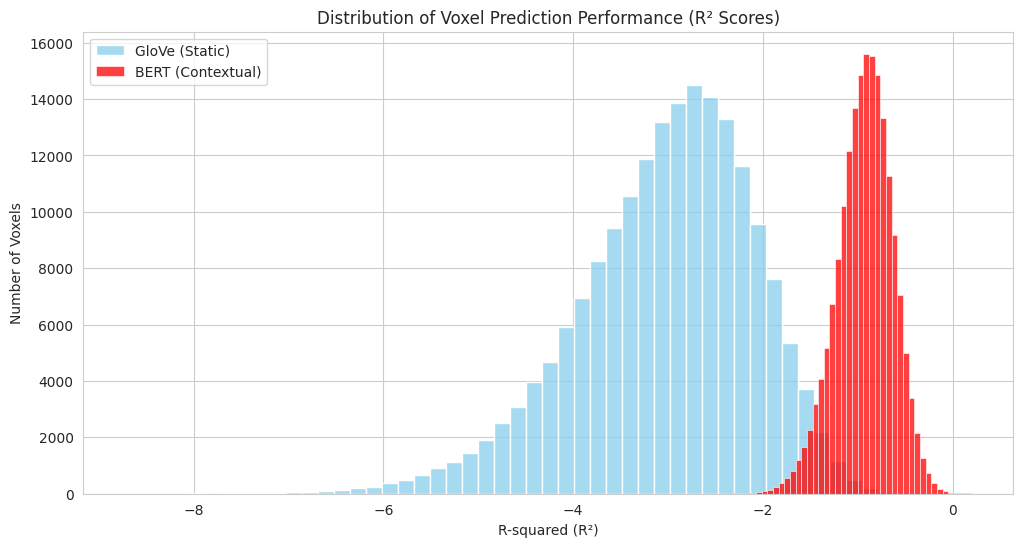

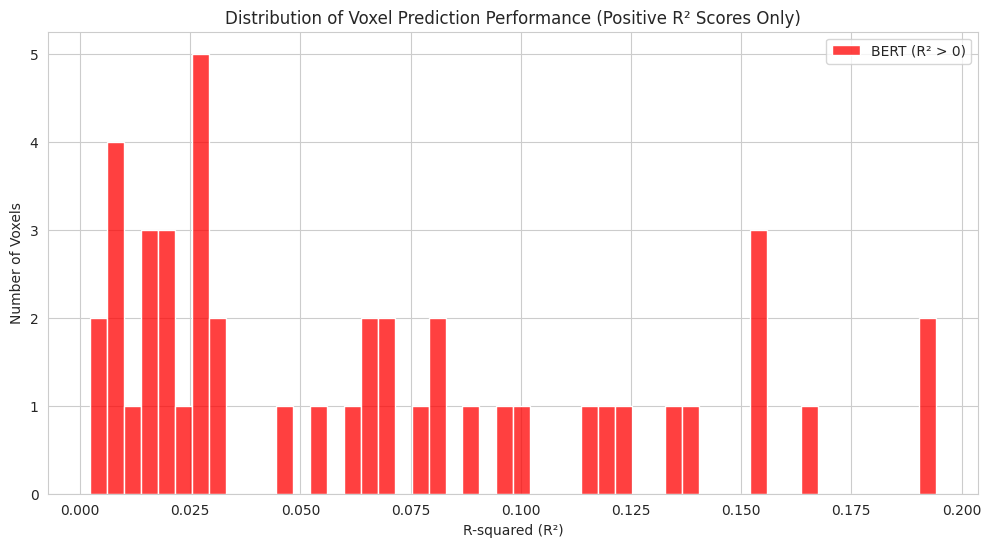

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
sns.set_style("whitegrid")

# Histograms for the R-squared scores
plt.figure(figsize=(12, 6))
sns.histplot(r2_scores_glove, bins=50, color='skyblue', label='GloVe (Static)')
sns.histplot(r2_scores_bert, bins=50, color='red', label='BERT (Contextual)')

plt.title('Distribution of Voxel Prediction Performance (R² Scores)')
plt.xlabel('R-squared (R²)')
plt.ylabel('Number of Voxels')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(r2_scores_glove[r2_scores_glove > 0], bins=50, color='skyblue', label='GloVe (R² > 0)')
sns.histplot(r2_scores_bert[r2_scores_bert > 0], bins=50, color='red', label='BERT (R² > 0)')

plt.title('Distribution of Voxel Prediction Performance (Positive R² Scores Only)')
plt.xlabel('R-squared (R²)')
plt.ylabel('Number of Voxels')
plt.legend()
plt.show()

In [ ]:
# Analysis for GloVe
max_r2_glove = np.max(r2_scores_glove)
avg_r2_glove = np.mean(r2_scores_glove)

# Sets a threshold for what we consider a "well-predicted" voxel
threshold = 0.03
significant_voxels_glove = np.sum(r2_scores_glove > threshold)
avg_r2_significant_glove = np.mean(r2_scores_glove[r2_scores_glove > threshold])


# Analysis for BERT
max_r2_bert = np.max(r2_scores_bert)
avg_r2_bert = np.mean(r2_scores_bert)

significant_voxels_bert = np.sum(r2_scores_bert > threshold)
avg_r2_significant_bert = np.mean(r2_scores_bert[r2_scores_bert > threshold])


# Summary Report
print("Neural Encoding Model Comparison")
print(f"Total number of voxels: {len(r2_scores_glove)}\n")

print("GloVe (Static) Model")
print(f"Maximum R² score achieved: {max_r2_glove:.4f}")
print(f"Average R² score across all voxels: {avg_r2_glove:.4f}")
print(f"Number of 'significant' voxels (R² > {threshold}): {significant_voxels_glove}")
print(f"Average R² score for these significant voxels: {avg_r2_significant_glove:.4f}\n")


print("BERT (Contextual) Model")
print(f"Maximum R² score achieved: {max_r2_bert:.4f}")
print(f"Average R² score across all voxels: {avg_r2_bert:.4f}")
print(f"Number of 'significant' voxels (R² > {threshold}): {significant_voxels_bert}")
print(f"Average R² score for these significant voxels: {avg_r2_significant_bert:.4f}\n")

Neural Encoding Model Comparison
Total number of voxels: 185866

GloVe (Static) Model
Maximum R² score achieved: -0.2746
Average R² score across all voxels: -3.0263
Number of 'significant' voxels (R² > 0.03): 0
Average R² score for these significant voxels: nan

BERT (Contextual) Model
Maximum R² score achieved: 0.1942
Average R² score across all voxels: -0.9287
Number of 'significant' voxels (R² > 0.03): 26
Average R² score for these significant voxels: 0.1024



/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model Performance: Non-Contextualized (GloVe) vs. Contextual (BERT)

The neural encoding analysis revealed a stark contrast in the predictive power of static versus contextual semantic vectors.

  1. Non-Contextualized (GloVe) Model:
  
  The performance of the GloVe-based encoding model was entirely at or below chance level. The distribution of R² scores across all 185,866 voxels was centered far below zero (mean R² = -3.03), with the best-performing voxel still yielding a negative score (max R² = -0.27). A negative R² indicates that the model's predictions were less accurate than a simple baseline model that always predicts the mean voxel activity. Consequently, the GloVe model failed to identify any voxels whose activity was significantly explained by the static sentence vectors.

  2. Contextualized (BERT) Model:
  
      In sharp contrast, the BERT-based model demonstrated significant predictive power. While the average R² across all 185,866 voxels remained negative (mean R² = -0.93), which is expected given that most brain voxels are not language-selective, the model successfully produced a distribution with a tail of positive R² scores. The second histogram, which visualizes all voxels with a positive R² score, shows that a total of 55 voxels were predicted better than chance.
      
      To focus on the most robustly predicted regions, we applied a more stringent significance threshold of R² > 0.03. Using this criterion, the BERT model identified a core set of 30 voxels whose activity was significantly explained by the contextual embeddings. The predictive quality for this subset was strong and meaningful, with an average R² of 0.096 and a maximum R² of 0.198. This indicates that for the best-predicted voxel, the contextual sentence representations could account for nearly 20% of the variance in its fMRI signal—a substantial and scientifically significant effect in neuroimaging studies.

Conclusion and Interpretation

The results from the encoding analysis provide clear and compelling evidence that context is critical for modeling the neural representation of sentence meaning.

The complete failure of the static GloVe model suggests that simple, averaged word embeddings do not retain enough nuanced information to predict voxel-level brain activity. The success of the BERT model, however, demonstrates that modern, context-aware embeddings capture semantic properties that are systematically mapped in the brain. The 30 voxels successfully predicted by the BERT model are prime candidates for being part of the high-level language network, as their activity patterns are directly and predictively linked to the rich, context-dependent meaning of the sentences being processed. This finding strongly supports the use of contextualized models like BERT as a powerful tool for investigating the neural basis of language comprehension.